AttributeError: partially initialized module 'shap' has no attribute 'summary_plot' (most likely due to a circular import)

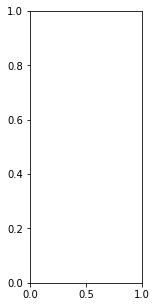

In [1]:
import os
import numpy as np
import sys
import pandas as pd
import json
import pickle
import sklearn.model_selection as ms
from sklearn import metrics
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import time

In [3]:
### headers for different groups of features

header = ['Metallicity', 'Altitude',
        'Mean Degree',
        'CO Degree', 'CH4 Degree', 'NH3 Degree', 'H2O Degree',
        'Average shortest path length',
        'Average clustering coefficient',
        'CO clustering coefficient', 'CH4 clustering coefficient', 'NH3 clustering coefficient','H2O clustering coefficient',
        'CO node betweenness centrality', 'CH4 node betweenness centrality', 'NH3 node betweenness centrality',
        'H2O node betweenness centrality',
        'Edge betweenness centrality',
        'Average neighbor degree',
        'CO neighbor degree', 'CH4 neighbor degree', 'NH3 neighbor degree', 'H2O neighbor degree',
        'CO abundance', 'CH4 abundance', 'NH3 abundance', 'H2O abundance',
        'Delta G distribution', 'Phi distribution',
        'Average node betweenness centrality', 'Temperature', 'kzz']

header_average = [
    'Mean Degree', 'Average shortest path length', 'Average clustering coefficient',
    'Average neighbor degree','Average node betweenness centrality', 'Edge betweenness centrality']

header_abundance = [n for n in header if n.find('abundance') > -1] # 'CO abundance', 'CH4 abundance', 'NH3 abundance', 'H2O abundance']

header_CO = [n for n in header if n.find('CO') > -1]
header_CO_without_abundance = list(header_CO)
header_CO_without_abundance.remove('CO abundance')

header_CH4 = [n for n in header if n.find('CH4') > -1]
header_CH4_without_abundance = list(header_CH4)
header_CH4_without_abundance.remove('CH4 abundance')

header_NH3 = [n for n in header if n.find('NH3') > -1]
header_NH3_without_abundance = list(header_NH3)
header_NH3_without_abundance.remove('NH3 abundance')

header_H20 = [n for n in header if n.find('H2O') > -1]
header_H20_without_abundance = list(header_H20)
header_H20_without_abundance.remove('H2O abundance')

header_individual_cc = [n for n in header if n.find('clustering coefficient') > -1]
header_individual_cc.remove('Average clustering coefficient')

header_individual_betweenness = [n for n in header if n.find('node betweenness centrality') > -1]
header_individual_betweenness.remove('Average node betweenness centrality')

header_individual_degree = [n for n in header if n.find('Degree') > -1 and n.find('neighbor degree') == -1]
header_individual_degree.remove('Mean Degree')

header_individual_neighborDegree = [n for n in header if n.find('neighbor degree') > -1]
header_individual_neighborDegree.remove('Average neighbor degree')

In [4]:
def XGB_accuracy(X, Y):
    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=0)
    eval_set = [(x_train, y_train), (x_test, y_test)]

    """ Fit the decision tree
    """
    # classifier = xgb.XGBClassifier(objective="multi:softprob", min_child_wight=1000, max_depth=2, n_estimators=10000)
    classifier = xgb.XGBClassifier(objective="multi:softprob", min_child_wight=10, max_depth=5, n_estimators=1000)
    classifier = classifier.fit(x_train, y_train, early_stopping_rounds=100, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    return metrics.accuracy_score(y_test, y_pred)


def XGB_shap(X, Y):

    # To supress warnings from shap
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=0)
    eval_set = [(x_train, y_train), (x_test, y_test)]

    """ Fit the decision tree
    """
    # classifier = xgb.XGBClassifier(objective="multi:softprob", min_child_wight=1000, max_depth=2, n_estimators=10000)
    classifier = xgb.XGBClassifier(objective="multi:softprob", min_child_wight=10, max_depth=5, n_estimators=1000)
    classifier = classifier.fit(x_train, y_train, early_stopping_rounds=100, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    # print('Accuracy Score: ', metrics.accuracy_score(y_test, y_pred))

    """ shapIT
    """
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(x_test)
    # shap.summary_plot(shap_values, X[30000:40000], plot_type='bar', class_names=["k = 0", "k = 1e06", "k = 1e08", "k = 1e10"],
    #                   class_inds='original')

    return shap_values

def shap_summary_plot(shap_values, X):
    shap.summary_plot(shap_values,  X[30000:40000], plot_type='bar', class_names=["k = 0", "k = 10^6", "k = 10^8", "k = 10^10"],
                     class_inds='original', show=False)#, sort=False)

In [5]:
### compute SHAP using different combination of G, topoAve, and abundance.

# dict_var = {'topo': header_average, 'ab': header_abundance,
#             'topo_ab': header_average + header_abundance,
#             'g_topo': ['Delta G distribution'] + header_average,
#             'g_ab': ['Delta G distribution'] + header_abundance}
#             #'g_topo_ab': ['Delta G distribution'] + header_average + header_abundance}
#
# for var in list(dict_var.keys()): #dict_var.keys():
#     var_name = dict_var[var]
#     dict_shap_values = dict()
#     for spread in ["50", "250", "1000"]: #spread
#
#         data_dir = "/Users/hkim78/work/2020-hotJupiter/data/atmosphere-uncertainty/%sk_spread/"%spread
#
#         dict_shap_values[spread] = dict()
#         for t in [400, 1200, 2000]:#np.arange(400, 2100, 100):
#             st = time.time()
#             print('starting')
#             print('var', var, 'spread', spread, 'temp', t)
#
#             data0 = pd.read_csv(data_dir + 'kzz0_temp%d_spread%s.csv'%(t, spread))
#             data1 = pd.read_csv(data_dir + 'kzz1_temp%d_spread%s.csv'%(t, spread))
#             data2 = pd.read_csv(data_dir + 'kzz2_temp%d_spread%s.csv'%(t, spread))
#             data3 = pd.read_csv(data_dir + 'kzz3_temp%d_spread%s.csv'%(t, spread))
#
#             frames = [data0, data1, data2, data3]
#             features = var_name + ['kzz']
#             allData = pd.concat(frames, ignore_index=True)
#
#             allData = allData[features]
#
#             """ Split into dependent and independent variables
#             """
#             X = allData.iloc[:, :-1]
#             Y = allData.iloc[:, -1].values
#
#             # a = XGB_accuracy(X, Y)
#             # dict_accuracy[spread].append(a)
#             dict_shap_values[spread][t] = XGB_shap(X, Y)
#
#             et = time.time()
#             print(et-st)
#
#     result_dir = "/Users/hkim78/work/2020-hotJupiter/ML/results/shap/"
#     output_path = result_dir + "shap_values_%s.dat"%var
#
#     with open(output_path, 'wb') as outfile:
#         pickle.dump(dict_shap_values, outfile)



In [6]:
## Plot for SHAP using different combination of G, topoAve, and abundance.

dir_ML = "/Users/hkim78/work/2020-hotJupiter/ML/results/shap/"
dict_var = {'topo': header_average, 'ab': header_abundance,
            'topo_ab': header_average + header_abundance,
            'g_topo': ['Delta G distribution'] + header_average,
            'g_ab': ['Delta G distribution'] + header_abundance}

dict_feature_names = {'Edge betweenness centrality': 'B_e',
                      'Average node betweenness centrality': 'B_n',
                      'Average shortest path length': 'L',
                      'Average clustering coefficient': 'C',
                      'Mean Degree': 'D',
                      'Average neighbor degree': 'K_nn',
                      'H2O abundance': '|H2O|',
                      'CH4 abundance': '|CH4|',
                      'CO abundance': '|CO|',
                      'NH3 abundance': '|NH3|',
                      'Delta G distribution': 'G'}

dir_plot = "/Users/hkim78/work/2020-hotJupiter/plot/atmosphere-uncertainty/shap_test/"

for var in list(dict_var.keys()): #dict_var.keys():
    var_name = dict_var[var]

    input_path = dir_ML + "shap_values_%s.dat"%var
    with open(input_path, 'rb') as infile:
        dict_shap = pickle.load(infile)

    for spread in ["50", "250", "1000"]:
        data_dir = "/Users/hkim78/work/2020-hotJupiter/data/atmosphere-uncertainty/%sk_spread/" % spread

        for t in [400, 1200, 2000]:
            data0 = pd.read_csv(data_dir + 'kzz0_temp%d_spread%s.csv'%(t, spread))
            data1 = pd.read_csv(data_dir + 'kzz1_temp%d_spread%s.csv'%(t, spread))
            data2 = pd.read_csv(data_dir + 'kzz2_temp%d_spread%s.csv'%(t, spread))
            data3 = pd.read_csv(data_dir + 'kzz3_temp%d_spread%s.csv'%(t, spread))

            frames = [data0, data1, data2, data3]
            features = var_name + ['kzz']
            allData = pd.concat(frames, ignore_index=True)

            allData = allData[features]

            """ Split into dependent and independent variables
            """
            X = allData.iloc[:, :-1]
            Y = allData.iloc[:, -1].values

            fig, ax = plt.subplots(figsize=(2,5))

            shap_summary_plot(dict_shap[spread][t], X)

            ax.set_title("%dK_spread%s"%(t, spread))

            labels_original = [item.get_text() for item in ax.get_yticklabels()]
            #print(labels_original)
            len_labels = len(labels_original)
            labels_new = list()
            for i in range(len_labels):
                labels_new.append(dict_feature_names[labels_original[i]])
            ax.set_yticklabels(labels_new)
            ax.set_xlabel("average impact")
            ax.legend(loc=4)
            plt.gcf().set_size_inches(3.5, 3.8)
            plt.tight_layout()
            plt.savefig(dir_plot + "shap_temp%d_spread%s_%s.png" % (t, spread, var))
            plt.savefig(dir_plot + "shap_temp%d_spread%s_%s.pdf" % (t, spread, var))
            plt.show()




NameError: name 'plt' is not defined